In [5]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd
from scipy.constants import c
from scipy.integrate import quad
import scipy.stats

#Nested sampling package
import ultranest
import corner

# I. Import data

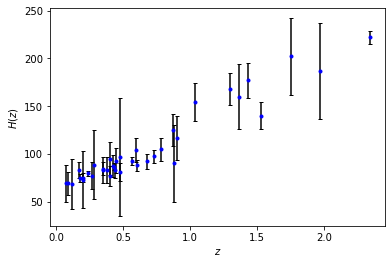

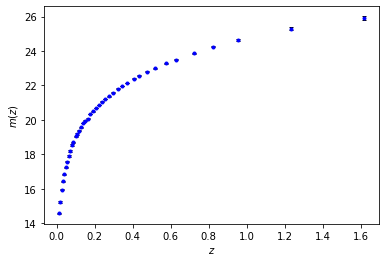

In [6]:
# Import Hubble H(z) data

hubble_data = pd.read_csv('hubble_data.csv', header=0)

z_H = np.array(hubble_data['z'])
H = np.array(hubble_data['H'])
dH = np.array(hubble_data['dH'])

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

# Import apparent magnitude m(z) data
m_data = pd.read_csv('m_data.txt', sep = ' ', header = 0)
m_sys_unc = pd.read_csv('m_sys_unc.txt', sep = ' ', header = 0)
m_sys_unc = np.array(m_sys_unc['40']).reshape(40, 40)

tot = m_sys_unc + np.diag(m_data['dmb']**2)

z_m = np.array(m_data['zcmb'])
m = np.array(m_data['mb'])
dm = np.sqrt(np.diag(tot))

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

# Combine redshifts for likelihood computation later
combined_z = []
combined_z.append(z_H)
combined_z.append(z_m)

# Combine data
combined_data = []
combined_data.append(H)
combined_data.append(m)

# Combine uncertainties
combined_unc = []
combined_unc.append(dH)
combined_unc.append(dm)

# II. Define models

In [7]:
'Define LCDM Hubble model'
def LCDM(z, params):
    H0 = params[0] 
    OM = params[1]
    OL = params[2]
    
    return H0*np.sqrt(OM*(1+z)**3 + OL)

'Define Domain Walls Model'
def DomainWalls(z, params):
    H0 = params[0] 
    OM = params[1] 
    OD = params[2]
    
    return H0*np.sqrt(OM*(1+z)**3 + OD*(1+z)**(1/3))

'Define apparent magnitude function'
def ApparentMagnitude(z, Hubble, params):
    
    def integrand_dl(z, Hubble, params):
    #integrand of luminosity distance formula
        return params[0]/Hubble(z, params)

    def dl(z, Hubble, params):
    #dimensionless luminosity distance at redshift z (input array)
        rz_array = np.zeros(len(z))
        for i in np.arange(len(z)):
            rz_each = quad( integrand_dl, 0, z[i],
                        args = (Hubble, params) )[0]
            rz_array[i] = rz_each
            
        return (1+z)*rz_array
    
    return 5*np.log10((c*100/params[0])*dl(z, Hubble, params)) - 19.25

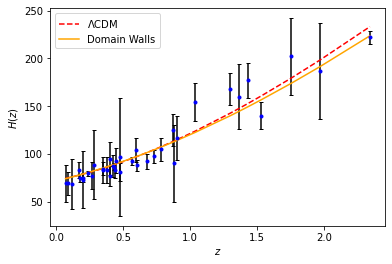

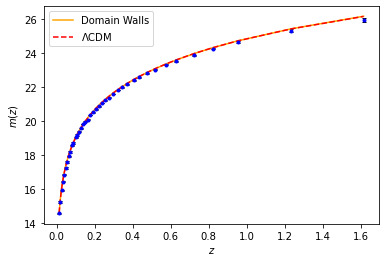

In [8]:
params_lcdm = [72.21, 0.26, 0.74]
params_domainwalls = [73.37, 0.22, 0.73]

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_H, LCDM(z_H, params_lcdm), color='red', ls='--', label=r'$\Lambda$CDM')
plt.plot(z_H, DomainWalls(z_H, params_domainwalls), color='orange', label='Domain Walls')
plt.legend(loc='best')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_m, ApparentMagnitude(z_m, DomainWalls, params_domainwalls), color='orange', label='Domain Walls')
plt.plot(z_m, ApparentMagnitude(z_m, LCDM, params_lcdm), color='red', ls='--', label=r'$\Lambda$CDM')
plt.legend(loc='best')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

# III. Nested Sampling: LCDM

In [9]:
def Prior_LCDM(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #OM Prior: [0,1]
    OM_min = 0
    OM_max = 1
    
    #OL Prior: [0,1]
    OL_min = 0
    OL_max = 1 
    
    #M Prior: [0,1]
    #M_min = -21
    #M_max = -18
    
    #Extract values
    H0prime = cube[0]
    OMprime = cube[1]
    OLprime = cube[2]
    #Mprime = cube[3]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    OM = OMprime*(OM_max-OM_min) + OM_min
    OL = OLprime*(OL_max-OL_min) + OL_min
    #M = Mprime*(M_max-M_min) + M_min
        
    return np.array([H0, OM, OL])
    
def LogLikelihood_LCDM(params):
    
#     if params[1] + params[2] > 1:
#         return -10**3
        

    # calculate the model
    hubble_model = LCDM(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, LCDM, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [10]:
t_i = time()
sampler_LCDM = ultranest.ReactiveNestedSampler(['H0', 'OM', 'OL'], LogLikelihood_LCDM, Prior_LCDM)
result_LCDM = sampler_LCDM.run()
sampler_LCDM.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-37.4498..-37.4498]*| it/evals=5566/138291 eff=4.0365% N=400        00   
[ultranest] Likelihood function evaluations: 138291
[ultranest]   logZ = -46.74 +- 0.09043
[ultranest] Effective samples strategy satisfied (ESS = 1566.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -46.756 +- 0.212
  single instance: logZ = -46.756 +- 0.144
  bootstrapped   : logZ = -46.736 +- 0.212
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  76.8 +- 9.7
    OM                  0.243 +- 0.058
    OL                  0.72 +- 0.17
Sampling time: 574.0211269855499 s


In [11]:
points_LCDM = np.array(result_LCDM["weighted_samples"]["points"])
weights_LCDM = np.array(result_LCDM["weighted_samples"]["weights"])
scaledweights_LCDM = weights_LCDM / weights_LCDM.max()
mask_LCDM = np.random.rand(len(scaledweights_LCDM)) < scaledweights_LCDM

samples_LCDM = points_LCDM[mask_LCDM, :]

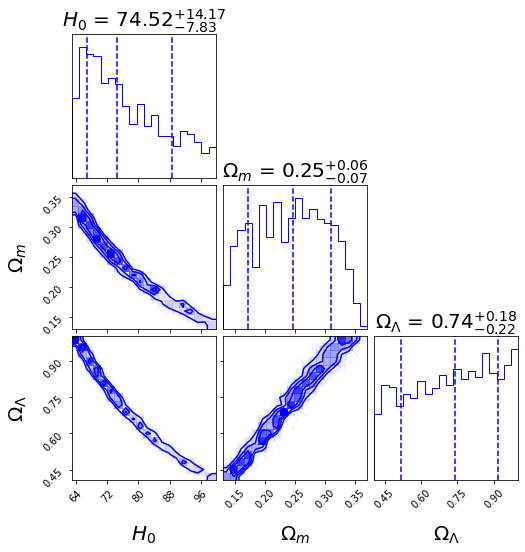

In [12]:
# Open saved samples
def open_samples(file):
    
    chains = pd.read_csv(file)
    nparams = len(chains.columns)
        
    if nparams == 2:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]))).T
    if nparams == 3:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]))).T
    if nparams == 4:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]), np.array(chains.iloc[:, 3]))).T
    
    return samples

# Extract and compile chains
lcdm_chain_1 = samples_LCDM[:,0] # extract chain of H0 values
lcdm_chain_2 = samples_LCDM[:,1] # extract chain if OM values
lcdm_chain_3 = samples_LCDM[:,2] # extract chain if OL values
lcdm_samples = np.vstack((lcdm_chain_1, lcdm_chain_2, lcdm_chain_3)).T

# Save chains and evidence (do not forget)
np.savetxt('lcdm_chains_Aug11_713PM.csv', lcdm_samples, delimiter=",")
np.savetxt('lcdm_Z_Aug11_713PM.csv', [[result_LCDM['logz'] , result_LCDM['logzerr']]])

# Open saved chains
samples_open =  open_samples('lcdm_chains_Aug11_713PM.csv')

fig = corner.corner(samples_open, labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('lcdm_Aug11_713PM.pdf')

# IV. Nested Sampling: Domain Walls

In [13]:
def Prior_DW(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #OM Prior: [0,1]
    OM_min = 0
    OM_max = 1
    
    #OL Prior: [0,1]
    OD_min = 0
    OD_max = 1 
    
    #Extract values
    H0prime = cube[0]
    OMprime = cube[1]
    ODprime = cube[2]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    OM = OMprime*(OM_max-OM_min) + OM_min
    OD = ODprime*(OD_max-OD_min) + OD_min
        
    return np.array([H0, OM, OD])
    
def LogLikelihood_DW(params):
        

    # calculate the model
    hubble_model = DomainWalls(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, DomainWalls, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [14]:
t_i = time()
sampler_DW = ultranest.ReactiveNestedSampler(['H0', 'OM', 'OL'], LogLikelihood_DW, Prior_DW)
result_DW = sampler_DW.run()
sampler_DW.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-36.6144..-36.6144]*| it/evals=5599/138386 eff=4.0577% N=400        00 0  
[ultranest] Likelihood function evaluations: 138386
[ultranest]   logZ = -45.99 +- 0.1386
[ultranest] Effective samples strategy satisfied (ESS = 1594.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.38, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -46.005 +- 0.281
  single instance: logZ = -46.005 +- 0.145
  bootstrapped   : logZ = -45.991 +- 0.281
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  77.3 +- 9.6
    OM                  0.208 +- 0.049
    OL                  0.73 +- 0.17
Sampling time: 613.0103940963745 s


In [15]:
points_DW = np.array(result_DW["weighted_samples"]["points"])
weights_DW = np.array(result_DW["weighted_samples"]["weights"])
scaledweights_DW = weights_DW / weights_DW.max()
mask_DW = np.random.rand(len(scaledweights_DW)) < scaledweights_DW

samples_DW = points_DW[mask_DW, :]

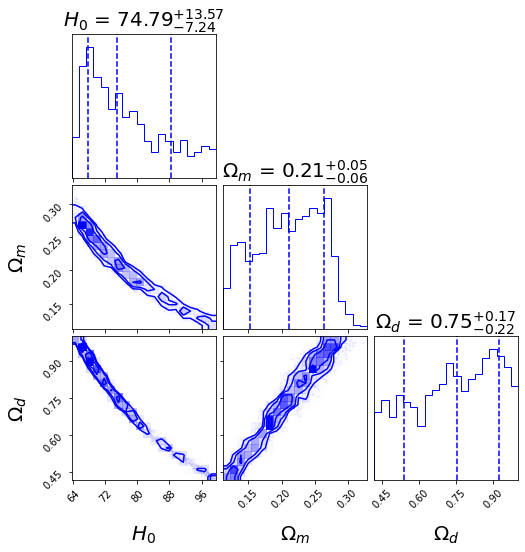

In [16]:
# Extract and compile chains
DomainWalls_chain_1 = samples_DW[:,0] # extract chain of H0 values
DomainWalls_chain_2 = samples_DW[:,1] # extract chain if OM values
DomainWalls_chain_3 = samples_DW[:,2] # extract chain if OL values
DomainWalls_samples = np.vstack((DomainWalls_chain_1, DomainWalls_chain_2, DomainWalls_chain_3)).T

# Save chains and evidence (do not forget)
np.savetxt('domainwalls_chains_Aug11_728PM.csv', DomainWalls_samples, delimiter=",")
np.savetxt('domainwalls_Z_Aug11_728PM.csv', [[result_DW['logz'] , result_DW['logzerr']]])

# Open saved chains
samples_open =  open_samples('domainwalls_chains_Aug11_728PM.csv')


fig = corner.corner(samples_open, labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_d$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('domainwalls_Aug11_728PM.pdf')


# V. Nested Sampling: LCDM with smaller unc

In [17]:
dH_mock = np.array([np.random.normal(loc = 0, scale = 5) for i in range(len(H))])

def LogLikelihood_LCDM_unc(params):
        

    # calculate the model
    hubble_model = LCDM(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, LCDM, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH_mock
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [18]:
t_i = time()
sampler_unc = ultranest.ReactiveNestedSampler(['H0', 'OM', 'OL'], LogLikelihood_LCDM_unc, Prior_LCDM)
result_unc = sampler_unc.run()
sampler_unc.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  192.58 [-1192.5866..-1192.5866]*| it/evals=6194/268023 eff=2.3144% N=400   0  
[ultranest] Likelihood function evaluations: 268023
[ultranest]   logZ = -1203 +- 0.1134
[ultranest] Effective samples strategy satisfied (ESS = 1651.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.26, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -1203.463 +- 0.208
  single instance: logZ = -1203.463 +- 0.157
  bootstrapped   : logZ = -1203.482 +- 0.208
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  73 +- 11
    OM                  0.315 +- 0.085
    OL                  0.69 +- 0.19
Sampling time: 1096.337182044983 s


In [19]:
points_unc = np.array(result_unc["weighted_samples"]["points"])
weights_unc = np.array(result_unc["weighted_samples"]["weights"])
scaledweights_unc = weights_unc / weights_unc.max()
mask_unc = np.random.rand(len(scaledweights_unc)) < scaledweights_unc

samples_unc = points_unc[mask_unc, :]

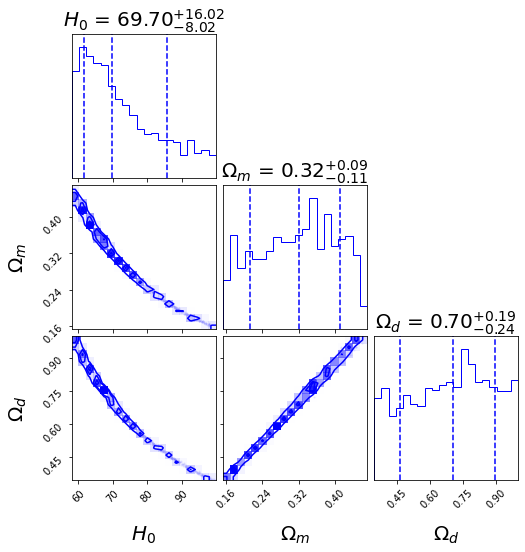

In [20]:
# Extract and compile chains
unc_chain_1 = samples_unc[:,0] # extract chain of H0 values
unc_chain_2 = samples_unc[:,1] # extract chain if OM values
unc_chain_3 = samples_unc[:,2] # extract chain if OL values
unc_samples = np.vstack((unc_chain_1, unc_chain_2, unc_chain_3)).T

# Save chains and evidence (do not forget)
np.savetxt('LCDM unc.csv', unc_samples, delimiter=",")
np.savetxt('LCDM unc Z.csv', [[result_unc['logz'] , result_unc['logzerr']]])

# Open saved chains
samples_open =  open_samples('LCDM unc.csv')


fig = corner.corner(unc_samples, labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_d$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('LCDM unc.pdf')


# VI. Nested Sampling: LCDM with Gaussian prior

In [21]:
def Prior_Gaussian(cube):

    H0 = scipy.stats.norm.ppf(cube[0], 72, 1)
    
    OM_min = 0
    OM_max = 1
    
    OD_min = 0
    OD_max = 1
    
    OMprime = cube[1]
    ODprime = cube[2]
    
    
    OM = OMprime*(OM_max-OM_min) + OM_min
    OD = ODprime*(OD_max-OD_min) + OD_min
    
    #OM = scipy.stats.norm.ppf(cube[1], 0.3111, 0.0056)
    #OD = scipy.stats.norm.ppf(cube[2], 0.6889, 0.0056)
        
    return np.array([H0, OM, OD])

In [22]:
t_i = time()
sampler_Gauss = ultranest.ReactiveNestedSampler(['H0', 'OM', 'OL'], LogLikelihood_LCDM, Prior_Gaussian)
result_Gauss = sampler_Gauss.run()
sampler_Gauss.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-37.4505..-37.4505]*| it/evals=5040/19968 eff=25.7563% N=400   0 0  
[ultranest] Likelihood function evaluations: 19968
[ultranest]   logZ = -45.45 +- 0.07663
[ultranest] Effective samples strategy satisfied (ESS = 1585.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -45.440 +- 0.151
  single instance: logZ = -45.440 +- 0.133
  bootstrapped   : logZ = -45.446 +- 0.151
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  71.99 +- 0.95
    OM                  0.264 +- 0.012
    OL                  0.789 +- 0.026
Sampling time: 123.20696306228638 s


In [23]:
points_Gauss = np.array(result_Gauss["weighted_samples"]["points"])
weights_Gauss = np.array(result_Gauss["weighted_samples"]["weights"])
scaledweights_Gauss = weights_Gauss / weights_Gauss.max()
mask_Gauss = np.random.rand(len(scaledweights_Gauss)) < scaledweights_Gauss

samples_unc = points_Gauss[mask_Gauss, :]

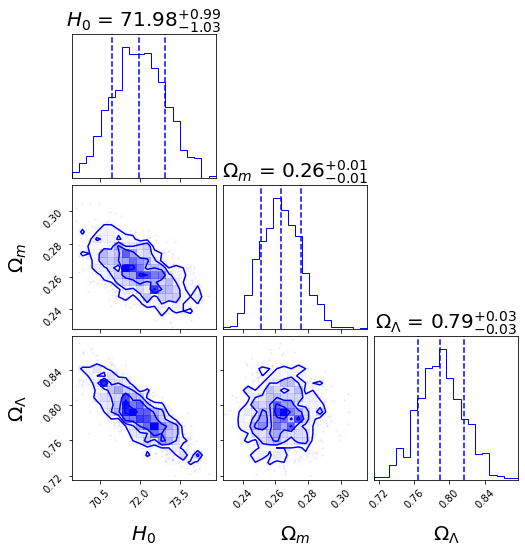

In [24]:
# Extract and compile chains
Gauss_chain_1 = samples_unc[:,0] # extract chain of H0 values
Gauss_chain_2 = samples_unc[:,1] # extract chain if OM values
Gauss_chain_3 = samples_unc[:,2] # extract chain if OL values
Gauss_samples = np.vstack((Gauss_chain_1, Gauss_chain_2, Gauss_chain_3)).T

# Save chains and evidence (do not forget)
np.savetxt('LCDM Gaussian.csv', Gauss_samples, delimiter=",")
np.savetxt('LCDM Gaussian Z.csv', [[result_Gauss['logz'] , result_Gauss['logzerr']]])

# Open saved chains
samples_open =  open_samples('LCDM unc.csv')


fig = corner.corner(Gauss_samples, labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_\Lambda$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('LCDM unc.pdf')
